请点击[此处](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576)查看本环境基本用法.  <br>
Please click [here ](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576) for more detailed instructions. 

## 一、项目背景介绍

随着移动互联网行业的快速发展，网络空间越来越成为人们生活中不可分割的一部分。每一天，都有数以亿计的用户访问各类新闻网页并留下评论，或是通过各种社交媒体发表自己对时事的观点和见解。尽管网友的言论大多都是友善和客观的，但其中也夹杂着许多无意间传播的不实言论，甚至是极少数不法分子刻意编织的谣言。这些虚假或恶意的内容如果不加以清理，就可能对不明真相的人们产生误导，从而带来众多不良影响。由于人力资源是有限且宝贵的，利用合适的算法对海量的信息进行初步筛选和甄别就显得十分重要。

## 二、数据介绍

**数据集介绍：** 

**数据来源：** 中文谣言新闻数据集 https://github.com/thunlp/Chinese_Rumor_Dataset

**归类领域：** 数据以文本信息为主，可用于文本分类等问题的研究。

**数据类型及样本信息：**

数据集一：data/rumors_v170613.json文件数据为从2009年9月4日至2017年6月12日的31669条谣言，数据格式如下。

rumorCode: 该条谣言的唯一编码，可以通过该编码直接访问该谣言举报页面。

title: 该条谣言被举报的标题内容

informerName: 举报者微博名称

informerUrl: 举报者微博链接

rumormongerName: 发布谣言者的微博名称

rumormongerUr: 发布谣言者的微博链接

rumorText: 谣言内容

visitTimes: 该谣言被访问次数

result: 该谣言审查结果

publishTime: 该谣言被举报时间

数据集二：CED_Dataset文件夹中数据为与微博原文相关的转发与评论信息，共包含谣言1538条和非谣言1849条，其中所有微博原文（包含谣言与非
谣言）在original-microblog文件夹中，剩余两个文件夹non-rumor-repost和rumor-repost分别包含非谣言原文与谣言原文的对应的转发与
评论信息，数据文件均为json格式。

微博原文信息：

text: 微博原文的文字内容

user: 发布该条微博原文的用户信息

time: 用户发布该条微博原文的时间（时间戳格式）

转发/评论信息：

uid: 发布该转发/评论的用户ID

text: 转发/评论的文字内容（若部分用户转发时不添加评论内容，该项无内容）

data: 该转发/评论的发布时间（格式如：2014-07-24 14:37:38）


本项目中训练阶段主要使用的数据集为数据集二。测试利用数据集一的样本完成

In [31]:
# 解压你所挂载的数据集在同级目录下
!unzip /home/aistudio/data/data20519/Rumor_Dataset.zip -d work/Rumor_Dataset-master

# 查看数据集的目录结构
! tree work/Rumor_Dataset-master -dhh

Archive:  /home/aistudio/data/data20519/Rumor_Dataset.zip
replace work/Rumor_Dataset-master/Chinese_Rumor_Dataset-master/rumors_v170613.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C
work/Rumor_Dataset-master
├── Chinese_Rumor_Dataset-master
│   └── CED_Dataset
│       ├── non-rumor-repost
│       ├── original-microblog
│       └── rumor-repost
└── __MACOSX
    └── Chinese_Rumor_Dataset-master
        └── CED_Dataset
            ├── non-rumor-repost
            ├── original-microblog
            └── rumor-repost

11 directories


In [3]:
! find ./work/Rumor_Dataset-master/Chinese_Rumor_Dataset-master/CED_Dataset/original-microblog/ -type f -print | wc -l 

3388


In [1]:
import json
import zipfile
import os
import random

work_path = '/home/aistudio/work/'
target_path = '/home/aistudio/work/Rumor_Dataset-master/'
target_folder = "/Chinese_Rumor_Dataset-master/CED_Dataset/original-microblog/"
original_microblog_dic = os.listdir(target_path + target_folder)

# 谣言标签设置为1，非谣言标签设置为0
non_rumor_label="0"
rumor_label="1"

all_samples_list = []

for original_file in original_microblog_dic:
    if (original_file != '.DS_Store'):
        file_num = int(original_file.split('_')[0])
        with open(target_path + target_folder + original_file, 'r', encoding="utf-8") as f:
            original_content = f.read()
        original_dict = json.loads(original_content)
        if file_num <= 2600:
            label = rumor_label
        else:
            label = non_rumor_label
        all_samples_list.append(label+"\t"+original_dict["text"]+"\n")

print(len(all_samples_list))

3387


In [2]:
# 数据乱序后写入text文件

data_txt_path="/home/aistudio/work/all_data.txt"

random.shuffle(all_samples_list)

with open(data_txt_path, 'w') as f:
    f.seek(0)
    f.truncate() 
    
with open(data_txt_path, 'a') as f:
    for data in all_samples_list:
        f.write(data) 

In [3]:
# 导入必要的包
import os
from multiprocessing import cpu_count
import numpy as np
import shutil
import paddle
import paddle.fluid as fluid
from PIL import Image
import matplotlib.pyplot as plt
import math

# 生成数据字典（按单个字符划分）
def create_dict(data_path, dict_path):

    # 先清空用于保存字典的txt文件
    with open(dict_path, 'w') as f:
        f.seek(0)
        f.truncate() 

    dict_set = set()
    # 读取全部数据
    with open(data_path, 'r', encoding='utf-8') as f:
        lines = f.readlines()
    # 把数据生成一个元组
    for line in lines:
        content = line.split('\t')[-1].replace('\n', '')
        for s in content:
            dict_set.add(s)
    # 把元组转换成字典，一个字对应一个数字
    dict_list = []
    i = 0
    for s in dict_set:
        dict_list.append([s, i])
        i += 1
    # 添加未知字符
    dict_txt = dict(dict_list)
    end_dict = {"<unk>": i}
    dict_txt.update(end_dict)
    # 把这些字典保存到本地中
    with open(dict_path, 'w', encoding='utf-8') as f:
        f.write(str(dict_txt))
    print("数据字典生成完成！")

    # 获取字典的长度
def get_dict_len(dict_path):
    with open(dict_path, 'r', encoding='utf-8') as f:
        line = eval(f.readlines()[0])
    return len(line.keys())

    

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/__init__.py:107: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import MutableMapping
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/rcsetup.py:20: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable, Mapping
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/colors.py:53: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sized


In [4]:
# 创建序列化表示的数据,并按照一定比例划分训练数据与验证数据
def create_data_list(data_list_path, eval_index):

    with open(os.path.join(data_list_path, 'train_list.txt'), 'w', encoding='utf-8') as f_train:
        f_train.seek(0)
        f_train.truncate()    # 将train.txt文件清空，下同

    with open(os.path.join(data_list_path, 'eval_list.txt'), 'w', encoding='utf-8') as f_eval:
        f_eval.seek(0)
        f_eval.truncate()   
        
    with open(os.path.join(data_list_path, 'dict.txt'), 'r', encoding='utf-8') as f_data:
        dict_txt = eval(f_data.readlines()[0])       # 将数据字典全部读出

    with open(os.path.join(data_list_path, 'all_data.txt'), 'r', encoding='utf-8') as f_data:
        lines = f_data.readlines()     # 全部文本以列表形式给出
  
    i = 0
    with open(os.path.join(data_list_path, 'eval_list.txt'), 'a', encoding='utf-8') as f_eval,open(os.path.join(data_list_path, 'train_list.txt'), 'a', encoding='utf-8') as f_train:
        for line in lines:
            words = line.split('\t')[-1].replace('\n', '')
            label = line.split('\t')[0]
            labs = ""
            for s in words:
                lab = str(dict_txt[s])
                labs = labs + lab + ','   # 用','将字符分开
            labs = labs[:-1]       # 去掉最后一个','
            labs = labs + '\t' + label + '\n'
            if i <= eval_index:
                f_train.write(labs)
            else:
                f_eval.write(labs)
            i += 1
        
    print("训练集与测试集划分完成！")

In [5]:
dict_path = work_path + "dict.txt"
eval_index = math.ceil(len(all_samples_list) * 0.8)

create_dict(data_txt_path, dict_path)

create_data_list(work_path, eval_index)

数据字典生成完成！
训练集与测试集划分完成！


In [6]:
# 定义数据映射模块
def data_mapper(sample):
    data, label = sample
    data = [int(data) for data in data.split(',')]
    return data, int(label)

#定义数据读取器（利用 paddle.reader.xmap_readers进行多线程读取）
def data_reader(data_path):
    def reader():
        with open(data_path, 'r') as f:
            lines = f.readlines()
            for line in lines:
                data, label = line.split('\t')
                yield data, label
    return paddle.reader.xmap_readers(data_mapper, reader, cpu_count(), 1024)

# 获取训练数据读取器和测试数据读取器
BATCH_SIZE = 128

train_list_path = work_path+'train_list.txt'
eval_list_path = work_path+'eval_list.txt'

train_reader = paddle.batch(
		reader=data_reader(train_list_path), 
		batch_size=BATCH_SIZE)
eval_reader = paddle.batch(
		reader=data_reader(eval_list_path), 
		batch_size=BATCH_SIZE)

## 三、模型介绍

借助PaddleNLP模块中的LSTM接口搭建了一个循环神经网络模型。

In [7]:
# 定义长短期记忆网络

def lstm_net(ipt, input_dim):

    # 以数据的IDs作为输入

    emb = fluid.layers.embedding(input=ipt, size=[input_dim, 128], is_sparse=True)

    # 第一个全连接层

    fc1 = fluid.layers.fc(input=emb, size=128)

    # 进行一个长短期记忆操作

    lstm1, _ = fluid.layers.dynamic_lstm(input=fc1, #返回：隐藏状态（hidden state），LSTM的神经元状态

                                         size=128) #size=4*hidden_size

    # 第一个最大序列池操作

    fc2 = fluid.layers.sequence_pool(input=fc1, pool_type='max')

    # 第二个最大序列池操作

    lstm2 = fluid.layers.sequence_pool(input=lstm1, pool_type='max')

    # 以softmax作为全连接的输出层，大小为2,也就是正负面

    out = fluid.layers.fc(input=[fc2, lstm2], size=2, act='softmax')

    return out

In [8]:
# 定义输入数据， lod_level不为0指定输入数据为序列数据
paddle.enable_static()
words = fluid.data(name='words', shape=[None,1], dtype='int64', lod_level=1)
label = fluid.data(name='label', shape=[None,1], dtype='int64')

In [9]:
# 获取数据字典长度
dict_dim = get_dict_len(dict_path)
# 获取分类器
model = lstm_net(words, dict_dim)   # words作为占位符

In [10]:
# 获取损失函数和准确率
cost = fluid.layers.cross_entropy(input=model, label=label)
avg_cost = fluid.layers.mean(cost)
acc = fluid.layers.accuracy(input=model, label=label)
# 获取预测程序
test_program = fluid.default_main_program().clone(for_test=True)

In [11]:
# 定义优化方法
optimizer = fluid.optimizer.AdagradOptimizer(learning_rate=0.001)
opt = optimizer.minimize(avg_cost)

## 四、模型训练

In [12]:
# use_cuda为False,表示运算场所为CPU;use_cuda为True,表示运算场所为GPU 
use_cuda = False 
place = fluid.CUDAPlace(0) if use_cuda else fluid.CPUPlace()
exe = fluid.Executor(place)     # 创建执行引擎
# 进行参数初始化
exe.run(fluid.default_startup_program())

# 定义数据映射器（生成一种特殊数据结构，以便输入到Executor中）
feeder = fluid.DataFeeder(place=place, feed_list=[words, label])

In [13]:
# 记录训练及验证时每回合的损失函数及准确率
all_train_iter=0
all_train_iters=[]
all_train_costs=[]
all_train_accs=[]

all_eval_iter=0
all_eval_iters=[]
all_eval_costs=[]
all_eval_accs=[]

# 训练及验证过程可视化
def draw_process(title,iters,costs,accs,label_cost,lable_acc):
    plt.title(title, fontsize=24)
    plt.xlabel("iter", fontsize=20)
    plt.ylabel("cost/acc", fontsize=20)
    plt.plot(iters, costs,color='red',label=label_cost) 
    plt.plot(iters, accs,color='green',label=lable_acc) 
    plt.legend()
    plt.grid()
    plt.show()

Pass:0, Batch:0, Cost:0.68558, Acc:0.56250
Test:0, Cost:0.65260, ACC:0.60532
Pass:1, Batch:0, Cost:0.63717, Acc:0.65625
Test:1, Cost:0.63481, ACC:0.72917
Pass:2, Batch:0, Cost:0.61402, Acc:0.75781
Test:2, Cost:0.61980, ACC:0.76780
Pass:3, Batch:0, Cost:0.59511, Acc:0.82031
Test:3, Cost:0.60889, ACC:0.77619
Pass:4, Batch:0, Cost:0.57802, Acc:0.86719
Test:4, Cost:0.59783, ACC:0.79123
Pass:5, Batch:0, Cost:0.56541, Acc:0.88281
Test:5, Cost:0.58893, ACC:0.79051
Pass:6, Batch:0, Cost:0.55022, Acc:0.88281
Test:6, Cost:0.58062, ACC:0.78776
Pass:7, Batch:0, Cost:0.53815, Acc:0.89062
Test:7, Cost:0.57085, ACC:0.79239
Pass:8, Batch:0, Cost:0.52789, Acc:0.89844
Test:8, Cost:0.56312, ACC:0.80093
Pass:9, Batch:0, Cost:0.51524, Acc:0.89844
Test:9, Cost:0.55239, ACC:0.80686
Pass:10, Batch:0, Cost:0.50512, Acc:0.91406
Test:10, Cost:0.54870, ACC:0.79890
Pass:11, Batch:0, Cost:0.49501, Acc:0.91406
Test:11, Cost:0.54195, ACC:0.79760
Pass:12, Batch:0, Cost:0.48594, Acc:0.91406
Test:12, Cost:0.53535, ACC:0

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2349: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if isinstance(obj, collections.Iterator):
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2366: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  return list(data) if isinstance(data, collections.MappingView) else data


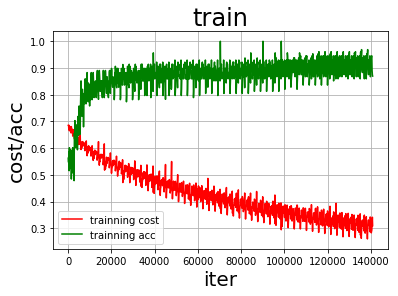

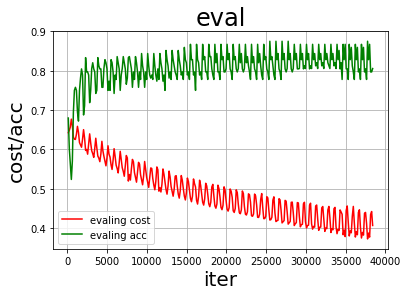

In [14]:
EPOCH_NUM=50                                        #训练轮数
model_save_dir = '/home/aistudio/work/infer_model/' #模型保存路径
# 开始训练
for pass_id in range(EPOCH_NUM):
    # 进行训练
    for batch_id, data in enumerate(train_reader()):
        train_cost, train_acc = exe.run(program=fluid.default_main_program(),
                             feed=feeder.feed(data),
                             fetch_list=[avg_cost, acc])
        all_train_iter=all_train_iter+BATCH_SIZE
        all_train_iters.append(all_train_iter)
        all_train_costs.append(train_cost[0])
        all_train_accs.append(train_acc[0])

        if batch_id % 100 == 0:
            print('Pass:%d, Batch:%d, Cost:%0.5f, Acc:%0.5f' % (pass_id, batch_id, train_cost[0], train_acc[0]))
    # 进行验证
    eval_costs = []
    eval_accs = []
    for batch_id, data in enumerate(eval_reader()):
        eval_cost, eval_acc = exe.run(program=test_program,     # fluid.default_main_program().clone(for_test=True)
                                              feed=feeder.feed(data),
                                              fetch_list=[avg_cost, acc])
        eval_costs.append(eval_cost[0])
        eval_accs.append(eval_acc[0])
        
        all_eval_iter=all_eval_iter+BATCH_SIZE
        all_eval_iters.append(all_eval_iter)
        all_eval_costs.append(eval_cost[0])                                       
        all_eval_accs.append(eval_acc[0])      
    # 计算平均预测损失在和准确率
    eval_cost = (sum(eval_costs) / len(eval_costs))
    eval_acc = (sum(eval_accs) / len(eval_accs))
    print('Test:%d, Cost:%0.5f, ACC:%0.5f' % (pass_id, eval_cost, eval_acc))

# 保存模型
if not os.path.exists(model_save_dir): 
    os.makedirs(model_save_dir) 
fluid.io.save_inference_model(model_save_dir, 
                            feeded_var_names=[words.name], 
                            target_vars=[model], 
                            executor=exe)
print('训练模型保存完成！') 

draw_process("train",all_train_iters,all_train_costs,all_train_accs,"trainning cost","trainning acc")
draw_process("eval",all_eval_iters,all_eval_costs,all_eval_accs,"evaling cost","evaling acc")

## 五、模型评估

In [29]:
# 创建执行器
place = fluid.CPUPlace()
infer_exe = fluid.Executor(place)
infer_exe.run(fluid.default_startup_program())

save_path = '/home/aistudio/work/infer_model/'

# 从模型中获取预测程序、输入数据名称列表、分类器
[infer_program, feeded_var_names, target_var] = fluid.io.load_inference_model(dirname=save_path, executor=infer_exe)


# 获取数据
def get_data(sentence):
    # 读取数据字典
    with open('/home/aistudio/work/dict.txt', 'r', encoding='utf-8') as f_data:
        dict_txt = eval(f_data.readlines()[0])
    dict_txt = dict(dict_txt)
    # 把字符串数据转换成列表数据
    keys = dict_txt.keys()
    data = []
    for s in sentence:
        # 判断是否存在未知字符
        if not s in keys:
            s = '<unk>'
        data.append(int(dict_txt[s]))
    return data

# 获取测试数据
test_path = 'work/Rumor_Dataset-master/Chinese_Rumor_Dataset-master/rumors_v170613.json'
file_rumors = open(test_path , 'r', encoding="utf-8") 
rumor_content = file_rumors.readlines()
all_samples = []
for line in rumor_content:
    dic = json.loads(line)
    all_samples.append(dic)
data = []
result_data = []
test_num = 5
for i in range(test_num):
    rumorText = all_samples_list[i]['rumorText']
    data.append(get_data(rumorText))
    if '不实' in all_samples_list[i]['result']:
        result_data.append('谣言')
    else:
        result_data.append('非谣言')

# 获取每句话的单词数量
base_shape = [[len(c) for c in data]]

# 生成预测数据
tensor_words = fluid.create_lod_tensor(data, base_shape, place)

# 执行预测
result = exe.run(program=infer_program,
                 feed={feeded_var_names[0]: tensor_words},
                 fetch_list=target_var)

# 分类名称
names = ['非谣言', '谣言']

# 进行预测并评价预测结果
right_num = 0
for i in range(len(data)):
    lab = np.argsort(result)[0][i][-1]
    print('预测结果标签为：%d， 分类为：%s， 概率为：%f， 真实结果为：%s' % (lab, names[lab], result[0][i][lab], result_data[i]))
    if names[lab] == result_data[i]:
        right_num += 1
acc_test = right_num / test_num
print('预测准确率为：%f' %(acc_test))

预测结果标签为：1， 分类为：谣言， 概率为：0.882589， 真实结果为：谣言
预测结果标签为：1， 分类为：谣言， 概率为：0.889681， 真实结果为：谣言
预测结果标签为：0， 分类为：非谣言， 概率为：0.577464， 真实结果为：谣言
预测结果标签为：1， 分类为：谣言， 概率为：0.686090， 真实结果为：谣言
预测结果标签为：1， 分类为：谣言， 概率为：0.673478， 真实结果为：谣言
预测准确率为：0.800000


## 六、总结与升华

由于之前没有做过NLP相关工作，为按时提交作业，本项目内容部分参考了之前的精品项目https://aistudio.baidu.com/aistudio/projectdetail/283337?channelType=0&channel=0

目前的版本预测准确度仍不算很高，除可以增加训练次数来提升模型效果外，还可以利用jieba等工具实现
精准分词来代替当前的以单个字符为单元的划分方式，并可对模型结构和参数进行优化和调试。接下来我将利用空余时间继续学习和实践，以求进一步完善此项目。

## 七、个人总结

项目作者：刘国栋

兴趣方向：数据挖掘

职业：电子工程师

个人博客：https://www.cnblogs.com/liugd-2020/p/

github: https://github.com/mofalong2000